## Topic classifier using BERT V2

V2 Version of topic classifier. Implementing several lessons from V1, including:
* More robust, useful data loading to actually handle debugging, EDA
* Implementing regularization, steps to avoid overfitting
* Abandoning DistillBERT in favor of larger transformer model, specifically `FacebookAI/roberta-base` which is case-sensitive AND has larger parameters, which may aid in allowing the model to distinguish between topics more effectively
* Roberta does not have, to my knowledge, a good fine-tuned model specifically for online article classification
* Potentially increase total dataset size so rarer classes have more training examples

In a separate notebook:
* Trying modern community standards such as `deberta-v3-base-zeroshot-v2.0` that don't require labelled training data

In [145]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from dotenv import load_dotenv
import os
import transformers
load_dotenv()  # looks for .env in current directory or parent
print(torch.__version__)
print(torch.cuda.is_available())


2.5.1
True


#### Follow the same data preparation steps

* Sample a dataset via query
* Filter out low-N topics

In [181]:
# Connect to server 
import psycopg2
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
cur = conn.cursor()

# key: set the seed
cur.execute("SELECT setseed(0.42)")

# Do our join in database
cur.execute(f"""
           SELECT gpt_topic,
           b.maintext
           FROM mm_framing_full a
           JOIN newsarticles b ON a.url = b.url
           ORDER BY RANDOM()
            LIMIT 90000
            """)

result= cur.fetchall()

print(cur.description)

cur.close()
conn.close()

df = pd.DataFrame(result, columns=["gpt_topic", "article_text"])
df.head()

del result

(Column(name='gpt_topic', type_code=25), Column(name='maintext', type_code=25))


In [157]:
df.head()

,gpt_topic,article_text
0,Crime,NEWYou can now listen to Fox News articles!\nA...
1,Business,The Transportation Security Administration (TS...
2,Sports,NEWYou can now listen to Fox News articles!\nF...
3,Immigration,It's hard enough to graduate from one of the m...
4,Politics,Pinned\nNikki Haley holds rally in South Carol...


In [158]:
## ESSENTIAL DATA FILTERING
# REMOVE rows that have less than 10 observations for the topic
# AND remove rows with less than 100 characters

counts = df.groupby('gpt_topic')['gpt_topic'].transform('count')

# 2. Filter the DataFrame
df_filtered = df[counts >= 10].copy()

# Remove less than 100 characters
min_words = 100
df_filtered = df_filtered[df_filtered['article_text'].str.split().str.len() >= min_words]

# 3. Check the result
print(f"Original rows: {len(df)}")
print(f"Filtered rows: {len(df_filtered)}")
print(f"Topics removed: {df['gpt_topic'].nunique() - df_filtered['gpt_topic'].nunique()}")
df = df_filtered

del df_filtered, counts

print(df['gpt_topic'].nunique)

Original rows: 90000
Filtered rows: 67170
Topics removed: 82
<bound method IndexOpsMixin.nunique of 0           Crime
1        Business
2          Sports
4        Politics
5        Politics
           ...   
89993       Crime
89996       Crime
89997      Sports
89998    Business
89999      Sports
Name: gpt_topic, Length: 67170, dtype: object>


In [159]:
# Consolidating labels to ~20 labels
category_mapping = {
    # 1. Politics & Global Affairs (Added 'Government')
    'Politics': 'Politics',
    'International Relations': 'Politics',
    'International': 'Politics',
    'Government': 'Politics',

    # 2. Crime & Safety
    'Crime': 'Crime & Safety',
    'Safety': 'Crime & Safety',
    'Public Safety': 'Crime & Safety',
    'Security': 'Crime & Safety',
    'Cybersecurity': 'Crime & Safety',

    # 3. Legal
    'Legal': 'Legal',

    # 4. Business & Economy (Added 'Consumer')
    'Business': 'Business & Economy',
    'Economy': 'Business & Economy',
    'Economics': 'Business & Economy',
    'Finance': 'Business & Economy',
    'Labor': 'Business & Economy',
    'Consumer': 'Business & Economy',

    # 5. Sports
    'Sports': 'Sports',

    # 6. Health
    'Health': 'Health',
    'Healthcare': 'Health',

    # 7. Entertainment (Added 'Celebrity')
    'Entertainment': 'Entertainment',
    'Celebrity': 'Entertainment',

    # 8. Lifestyle & Culture
    'Culture': 'Lifestyle & Culture',
    'Lifestyle': 'Lifestyle & Culture',
    'Travel': 'Lifestyle & Culture',
    'Food': 'Lifestyle & Culture',
    'Arts': 'Lifestyle & Culture',
    'Fashion': 'Lifestyle & Culture',
    'History': 'Lifestyle & Culture',
    'Religion': 'Lifestyle & Culture',
    'Family': 'Lifestyle & Culture',
    'Human Interest': 'Lifestyle & Culture',
    'Obituary': 'Lifestyle & Culture',

    # 9. Environment & Nature (Added 'Animals')
    'Environment': 'Environment & Nature',
    'Wildlife': 'Environment & Nature',
    'Animal Rights': 'Environment & Nature',
    'Animal': 'Environment & Nature',
    'Animals': 'Environment & Nature',
    'Animal Welfare': 'Environment & Nature',
    'Agriculture': 'Environment & Nature',

    # 10. War & Conflict
    'War': 'War & Conflict',
    'Military': 'War & Conflict',

    # 11. Science & Technology
    'Technology': 'Science & Technology',
    'Science': 'Science & Technology',

    # 12. Disaster & Accidents
    'Accident': 'Disaster & Accidents',
    'Accidents': 'Disaster & Accidents',
    'Disaster': 'Disaster & Accidents',
    'Disasters and Emergencies': 'Disaster & Accidents',
    'Natural Disasters': 'Disaster & Accidents',
    'Natural Disaster': 'Disaster & Accidents',
    'Emergency': 'Disaster & Accidents',

    # 13. Social Issues (Added 'Humanitarian')
    'Social Issues': 'Social Issues',
    'Social': 'Social Issues',
    'Society': 'Social Issues',
    'Community': 'Social Issues',
    'Charity': 'Social Issues',
    'Human Rights': 'Social Issues',
    'Humanitarian': 'Social Issues',

    # 14. Infrastructure & Transport
    'Transportation': 'Infrastructure & Transport',
    'Infrastructure': 'Infrastructure & Transport',
    'Housing': 'Infrastructure & Transport',
    'Urban Development': 'Infrastructure & Transport',

    # 15. Independent Mid-Sized Categories
    'Weather': 'Weather',
    'Education': 'Education',
    'Media': 'Media',
    'Immigration': 'Immigration',

    # 16. Handling Nulls/Other
    'no_topic': 'Other/Unknown',
    'No_topic': 'Other/Unknown'
}


In [160]:
df['topic_cat'] = df['gpt_topic'].astype('category')

# Create the new column
df['cleaned_topic'] = df['topic_cat'].map(category_mapping)

# IMPORTANT: .map() converts anything NOT in the dictionary to NaN (missing).
# Convert to other/unknown for simplicity, for these edge cases
df['cleaned_topic'] = df['cleaned_topic'].fillna('Other/Unknown')

# set dtype
df['cleaned_topic'] = df['cleaned_topic'].astype('category')

# Check your new reduced value counts
print(df['cleaned_topic'].value_counts())

df['cleaned_topic'].describe()

cleaned_topic
Politics                      11548
Sports                        10101
Crime & Safety                 8356
Business & Economy             5551
Legal                          4559
Lifestyle & Culture            3791
Health                         3458
Entertainment                  3304
Environment & Nature           2943
War & Conflict                 2062
Social Issues                  1893
Science & Technology           1599
Immigration                    1475
Education                      1366
Media                          1293
Other/Unknown                  1201
Disaster & Accidents           1185
Weather                         850
Infrastructure & Transport      635
Name: count, dtype: int64


count        67170
unique          19
top       Politics
freq         11548
Name: cleaned_topic, dtype: object

In [161]:
# rereate label_ids mapping (string --> int)
label_ids = df['cleaned_topic'].cat.codes
id_to_label = list(df['cleaned_topic'].cat.categories)
label_to_id = {label: i for i, label in enumerate(id_to_label)}
#label_to_id

In [162]:
df.columns

Index(['gpt_topic', 'article_text', 'topic_cat', 'cleaned_topic'], dtype='object')

### Tokenize + Apply custom head/tail truncation


In [163]:
from transformers import AutoTokenizer

# choosing a base tokenizer model, this won't 
model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# generally want to keep the tokenizations in a separate variable rather than adding them back to the dataframe (for efficiency, taking advantage of the batching features of the huggingface tokenizer)

encodings = tokenizer(df['article_text'].tolist(),                      # we opt to dynamically do padding later with head/tail strategy
                      # hence we also don't need truncation here
                      )

Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


In [164]:
# Code to set the unique head and tail of the articles
head_len = 320
tail_len = 190
content_len = head_len + tail_len          
max_len = content_len + 2  # [CLS] + [SEP]      

cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id

for i, ids in enumerate(encodings["input_ids"]):
    # ClS and Sep Id's are present in tokenized values, so do this
    if len(ids) >= 2 and ids[0] == cls_id and ids[-1] == sep_id:
        ids = ids[1:-1]

    # Head+tail on the content tokens
    if len(ids) > content_len:
        head = ids[:head_len]
        tail = ids[-tail_len:]
        ids = head + tail

    # Add specials back
    ids = [cls_id] + ids + [sep_id]

    # Build attention mask (1 for real tokens)
    mask = [1] * len(ids)

    # Pad (or truncate)
    if len(ids) < max_len:
        pad_n = max_len - len(ids)
        ids = ids + [pad_id] * pad_n
        mask = mask + [0] * pad_n
    else:
        ids = ids[:max_len]
        mask = mask[:max_len]

    # Write back
    encodings["input_ids"][i] = ids
    encodings["attention_mask"][i] = mask

# quick sanity check
for ids, mask in zip(encodings["input_ids"][:10], encodings["attention_mask"][:10]):
    assert len(ids) == 512 and len(mask) == 512
    print(ids[:3], sum(mask))

[0, 5341, 1185] 512
[0, 133, 6586] 459
[0, 5341, 1185] 407
[0, 44670, 7456] 512
[0, 5341, 1185] 512
[0, 40448, 6937] 512
[0, 9064, 5] 422
[0, 133, 4921] 512
[0, 5341, 1185] 512
[0, 250, 319] 312


### PyTorch Dataset Creation

Using `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`

[Pytorch data tutorial](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [165]:
# Modifying the below to record the raw text, but filter this out in batch processing since it's not a tensor

from torch.utils.data import Dataset

class NewsArticleDataset(Dataset):
    def __init__(self, encodings, label_ids: pd.Series, article_text: pd.Series):
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = label_ids.to_list() # convert to list for indexing robustness 
        self.article_text =  article_text.to_list() # convert as well
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        # for transformer style training, generally return a dict with keys that match what your model expects
        dict_to_return = {'input_ids': torch.tensor(self.input_ids[idx], dtype = torch.long), # convert to tensors, 64-bit integer (long) dtype 
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype = torch.long),
            'labels': torch.tensor(self.labels[idx], dtype =torch.long),
            'article_text': self.article_text[idx]} # no need to convert text to tensor
        return dict_to_return
        


### Creating the test/train/val split

Since we have so many unique classes (100+) it seems best to stratify our data split to balance class distributions.

Can use `sklearn.model_selection.train_test_split`

This finds the indexes for the splits

In [166]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# integer-coded labels aligned with encodings order
labels = np.array(label_ids, dtype=np.int64) # numpy array

N = len(labels)
idx = np.arange(N)

# 80/10/10 split (train/val/test), stratified
train_idx, temp_idx = train_test_split(
    idx,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=labels # as array
)

# Run it again on the temp test set to get the val set
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,                    # half of 20% -> 10% val, 10% test
    random_state=42,
    shuffle=True,
    stratify=labels[temp_idx]
)

# Build ONE dataset, then slice with Subset
full_df = NewsArticleDataset(encodings, label_ids, df['article_text'])  # or NewsArticleDataset(encodings, labels)
train = Subset(full_df, train_idx) # basically does what it says on the tin
val   = Subset(full_df, val_idx)
test  = Subset(full_df, test_idx)

print(len(train), len(val), len(test))



53736 6717 6717


In [167]:
# recreate the data loader, they rely on dataset + indices
batch_size = 16

from torch.utils.data import DataLoader

# data loaders handle our raw (non-tensor) article text automatically
train_loader = DataLoader(train, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          num_workers=0, # increase this later on
                          shuffle = True, 
                          pin_memory= True)
val_loader = DataLoader(val, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False, # false so eval is deterministic and reproducible
                          pin_memory= True)
test_loader = DataLoader(test, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False,  # false, as above
                          pin_memory= True)

In [168]:
# grab a batch using iterator next()
batch = next(iter(train_loader))

text = batch.pop("article_text", None)

print(batch)


{'input_ids': tensor([[    0,   565,   967,  ...,  1869, 22893,     2],
        [    0,   791,     4,  ...,     1,     1,     1],
        [    0,   133,   485,  ...,     1,     1,     1],
        ...,
        [    0, 42724,    34,  ...,  2687,     4,     2],
        [    0,   133,  4267,  ...,     1,     1,     1],
        [    0,   133,   394,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([ 6,  9, 13, 11, 13,  1,  6,  9, 11,  1, 16,  0, 11, 17,  0,  3])}


### Begin training loop

Overall training notes (unlike last notebook, not gonna keep a bunch of version of different training loops. Will just note my observations below, changing stuff flexibly)

#### Training Run 1 - 15 epochs - 3e-5 LR - 30,000 N 
* Took 106 minutes, val accuracy peaked at 0.74
Epoch 7 | train_loss=0.1688 | val_loss=1.2457 | val_acc=0.7439

* Having examined the incorrect predictions, I'm feeling significant empathy for the model. In these cases, the 'true label' is quite debatable, and it feels like both can fit for the article. It doesn't appear like anything is deeply wrong with the training parameters themselves, so much as it's a data-side issue. 
* A key trend is that the model has difficulty with short-length predictions, I will try parsing these out earlier in the pipeline
* Where the model does start to falter is in understanding moral nuances, for example an article about the killing of a grizzly bear was classified as: True label: Environment & Nature -- Pred label Crime & Safety, which is understandable but ideally this distinction would be picked up.

**Next steps: remove short articles (under 100? words) from training, increase N**
Epochs don't seem to help much, so keep at 3 for now. For fast iteration/testing

#### Training Run 2 - 3 epochs - 3e-5 LR - 67000 N
Epoch 2 | train_loss=0.5086 | val_loss=0.6973 | val_acc=0.7637
* Removed rows with less than 100 words, increase to 67170 total example (post filter)
* My thoughts are now that the task of the topic classification is a bit silly, I would even have a hard time concretely distinguishing between these
* I disagree with the original 


In [171]:
# for a clean state, hard reset the GPU state
import torch, gc
gc.collect()
torch.cuda.empty_cache() 

In [172]:
# Load model and head 
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(df['cleaned_topic'].unique()))
model.to('cuda')

# set optimizer and LR
optimizer = torch.optim.AdamW(lr=3e-5, # for transformers, we want a low learning rate, even lower than 0.001
                              weight_decay= 0.01, # this basically is L2 regularization applied through, penalizeing large weight, encouragin params to stay smaller, can help reduce overfitting and improve generalization
                             params=model.parameters()) # tell the optimizer what parameters to optimize


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [173]:
epochs = 3

for epoch in range(epochs):
    model.train()

    running_loss = 0.0

    for batch in train_loader:
        #0) pop out the article text
        article_text = batch.pop("article_text", None)
        
        # 1) move batch to GPU
        batch = {k: v.to("cuda") for k, v in batch.items()}

        # 2) forward pass 
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"] # had a rough comma here b4
        )

        loss = outputs.loss # default loss from the HF auto model, likely cross entropy
        running_loss += loss.item()

        # 3) zero grad
        optimizer.zero_grad()

        # 4) backward
        loss.backward()

        # 5) step
        optimizer.step()

    # ---- validation ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            #pop out text
            article_text = batch.pop("article_text", None)
            
            batch = {k: v.to("cuda") for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"],
            )
            val_loss += outputs.loss.item()

            logits = outputs.logits
            preds = logits.argmax(dim=-1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)

    print(
        f"Epoch {epoch} | train_loss={running_loss/len(train_loader):.4f} "
        f"| val_loss={val_loss/len(val_loader):.4f} | val_acc={correct/total:.4f}"
    )

Epoch 0 | train_loss=0.8702 | val_loss=0.6951 | val_acc=0.7625
Epoch 1 | train_loss=0.6357 | val_loss=0.7026 | val_acc=0.7588
Epoch 2 | train_loss=0.5086 | val_loss=0.6973 | val_acc=0.7637


### Test set evaluation/ exploration of predictions

In [174]:
## Error analysis on test set

test_results = []

with torch.no_grad():
    for batch in test_loader:
        article_text = batch.pop("article_text")
        batch = {k: v.to("cuda") for k, v in batch.items()}        
        outputs = model(**batch)       
        
        # Get predictions
        preds = outputs.logits.argmax(dim=-1)
        
        # Iterate through the batch to pair text with predictions
        # We move tensors back to CPU (.cpu()) and convert to python scalars (.item())
        current_labels = batch["labels"].cpu().numpy()
        current_preds = preds.cpu().numpy()
        
        for article_text, true_label, pred_label in zip(article_text, current_labels, current_preds):
            test_results.append({
                "article_text": article_text,
                "true_label": true_label,
                "pred_label": pred_label,
                "is_correct": true_label == pred_label
            })
         


    

In [175]:
# Create a dataframe
df_results = pd.DataFrame(test_results)

# create key to label mapping
id_to_label_dict = {id: label for label, id in label_to_id.items()}

# Convert label_ids back to true categories
df_results['true_label'] = df_results['true_label'].map(id_to_label_dict)
df_results['pred_label'] = df_results['pred_label'].map(id_to_label_dict)



# id_to_label = list(df['cleaned_topic'].cat.categories)

false_preds = df_results.query('is_correct == False').reset_index()

df_results.head()



,article_text,true_label,pred_label,is_correct
0,A body found in a river in West Nashville on F...,Crime & Safety,Crime & Safety,True
1,PITTSBURGH (AP) — The Pittsburgh Steelers will...,Sports,Sports,True
2,50 Cent isn’t feeling too hot about his “Expen...,Entertainment,Entertainment,True
3,Washington — An 8-year-old migrant girl from P...,Immigration,Immigration,True
4,Tom Cruise has high hopes for his future.\nThe...,Entertainment,Entertainment,True


In [176]:
index = 491

print(false_preds.iloc[index]['article_text'])
print("======================================")
print(f"True label: {false_preds.iloc[index]['true_label']} -- Pred label {false_preds.iloc[index]['pred_label']}")

DALLAS (AP) — Southwest Airlines has added former U.S. Senator Roy Blunt, a Republican from Missouri, to its board of directors.
Blunt, 73, spent 14 years in the U.S. House of Representatives and served in the Senate from 2011 until leaving office in January as the fourth-ranking Republican. He did not seek re-election last year.
Since April, Blunt has worked at Husch Blackwell Strategies, a Washington, D.C., lobbying firm that also employs his son and former aides. The firm said Blunt would focus on advising clients and did not plan to register as a lobbyist.
Southwest Chairman Gary Kelly said Monday in prepared remarks that Blunt’s experience as chairman of the Senate aviation subcommittee would be helpful to the airline.
The appointment took effect Sunday. Dallas-based Southwest now has 15 directors.
True label: Business & Economy -- Pred label Politics


<Axes: xlabel='true_label'>

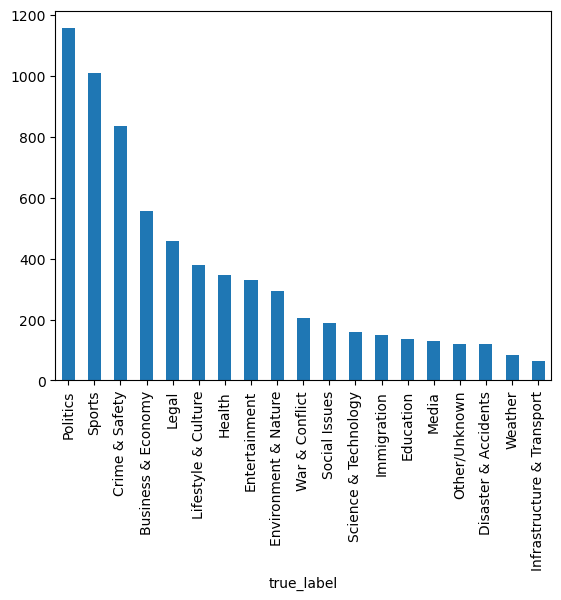

In [179]:
df_results['true_label'].value_counts().plot(kind='bar')

<Axes: xlabel='pred_label'>

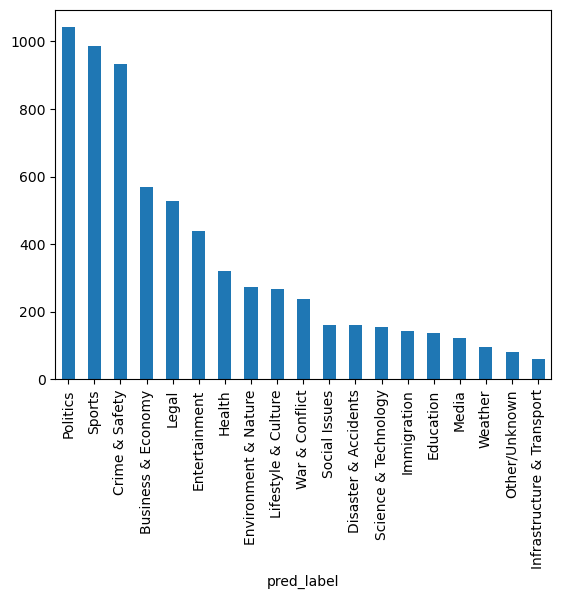

In [180]:
df_results['pred_label'].value_counts().plot(kind='bar')

In [ ]:
# Let's save the model

# model.save_pretrained("saved_models/final_topic_classifier")

# ALWAYS save the tokenizer with it, or you won't be able to process text later
# tokenizer.save_pretrained("saved_models/final_topic_classifier")

('saved_models/final_topic_classifier\\tokenizer_config.json',
 'saved_models/final_topic_classifier\\special_tokens_map.json',
 'saved_models/final_topic_classifier\\vocab.json',
 'saved_models/final_topic_classifier\\merges.txt',
 'saved_models/final_topic_classifier\\added_tokens.json',
 'saved_models/final_topic_classifier\\tokenizer.json')